In [94]:
import os
import numpy as np
import pandas as pd
from scipy import optimize
from scipy import linalg
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import array as arr
import seaborn as sns
import random
import pylab
from scipy import stats
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import inverse_method_funs as inv
import sys

In [95]:
sys.path.append('C://Users/mbd/phd')
import sb_tools

In [96]:
sns.set_theme(style="darkgrid")
sns.color_palette("viridis", as_cmap=True)
title_font = {
    'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black'}

## Upload required values

In [97]:
# Sv fil from Echoview ** Pulse compressed!
fname_EV = 'D:/GLIDER2018/Echosounder/EVexport/Wideband_frequency_response_28AM.csv'
#fname_EV = 'D:/GLIDER2018/Echosounder/EVexport/Wideband_frequency_response_25AM_surface.csv'
fname_noise = 'D:/GLIDER2018/Echosounder/EVexport/Wideband_frequency_response_noise.csv'
freqs_EV, sv = inv.read_widebandfrequencyresponse(fname_EV, extracols = 0)
f, sv_noise = inv.read_widebandfrequencyresponse(fname_noise, extracols = 1)
freqs_EV, sv_EV = inv.read_widebandfrequencyresponse(fname_EV, extracols = 2)

sv = np.array(sv,dtype=float)
sv_EV = np.array(sv_EV,dtype=float)
freqs_EV = np.array(freqs_EV,dtype=float)

In [98]:
# Sigmabs from ZooScatR model runs + viscous elactic model for mean of fish larvae model by ve=True)
fname_sim = '../ZooScatStuff/my_data.feather'
specs, freqs_sim, sig_bs_sim, sig_bs_mean = inv.read_scatteringmodelsimulations(fname_sim, nsim=1000, ve=True)

In [99]:
# Remove high noise frequencys
# Benoit Bird 2020 -  Removing frequency content reduced classification success.
#sv = sv[freqs_EV<375,:]
#freqs_EV = freqs_EV[freqs_EV<375]


Resample the simulation values to match the frequencies of the measured frequencies

In [100]:
sigma_bs = np.zeros([len(freqs_EV),np.shape(sig_bs_sim)[1],len(specs)])
sigma_bs_mean = np.zeros([len(freqs_EV),len(specs)])

for ind_spec in range(0,len(specs)):
    f = UnivariateSpline(freqs_sim,sig_bs_mean[:,ind_spec], k=5)
    sigma_bs_mean[:,ind_spec] = f(freqs_EV)
    for ind_sim in range(0,np.shape(sig_bs_sim)[1]):
        f = UnivariateSpline(freqs_sim,sig_bs_sim[:,ind_sim,ind_spec], k=5)
        sigma_bs[:,ind_sim,ind_spec] = f(sigma_bs_mean[:,ind_spec])

## Plot crossectional backscatter/TS
Here is the modelled scattering of each functional group. Linearly they are mostly all very similar (Limacina is not correct yet).

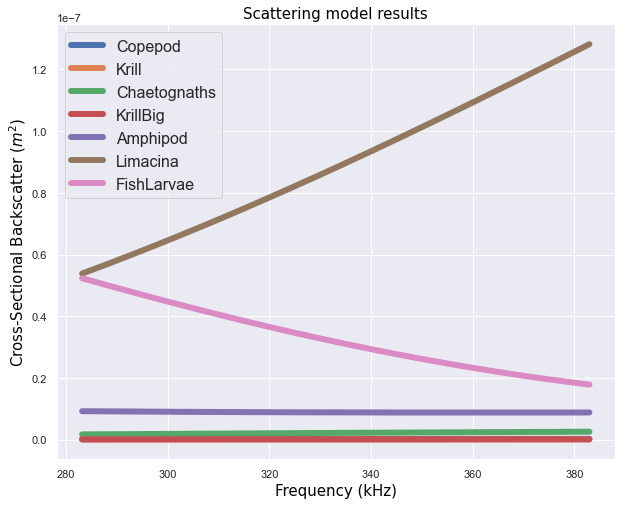

In [101]:
fig=plt.figure(figsize=(10, 8),facecolor='w', edgecolor='k')
plt.plot(freqs_EV,sigma_bs_mean, linewidth=6)
plt.legend(specs, fontsize=16)
plt.ylabel('Cross-Sectional Backscatter ($m^{2}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Scattering model results', title_font);

The differences between the scattering models are a bit more noticable in log terms (TS)

Text(0.5, 1.0, 'Scattering model results')

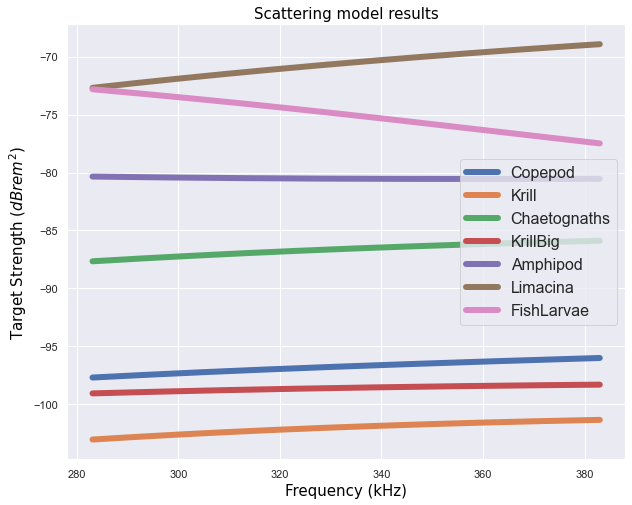

In [102]:
# Which cross-sectional backscatter simulation to choose... The mean is boring and shows no variability. 
fig=plt.figure(figsize=(10, 8),facecolor='w', edgecolor='k')
plt.plot(freqs_EV,10*np.log10(sigma_bs_mean), linewidth=6)
plt.legend(specs, fontsize=16)
plt.ylabel('Target Strength ($dB re m^{2}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Scattering model results', title_font)

# Least-Squares calculators
In linear terms, the equation is very simple. I am simply solving a linear regression:

\begin{equation}
\sigma_{bs} * Density = s_{v}\\
A X = Y
\end{equation}

scipy - optimize - lsq_linear\
For least-squares problems with bounds on the variables. I include bound of [0, inf) ; positive values

Start with default method: ‘trf’ : Trust Region Reflective algorithm adapted for a linear least-squares problem. This is an interior-point-like method and the required number of iterations is weakly correlated with the number of variables. **These results look like a really good start to me**

In [103]:
# Also try with sv median
sv_smooth, ci = sb_tools.sv_smooth_ci(sv, N=30)

In [104]:
density = np.zeros([np.shape(sigma_bs_mean)[1], np.shape(sv)[1]])
sigbs = sigma_bs_mean
for ind in range(0, np.shape(sv)[1]):
    d = optimize.lsq_linear(sigbs, sv[:,ind], bounds=(0,np.inf))
    density[:,ind] = d.x
d = optimize.lsq_linear(sigbs, sv_smooth, bounds=(0,np.inf))
density = d.x

Text(0.5, 0, 'Functional group')

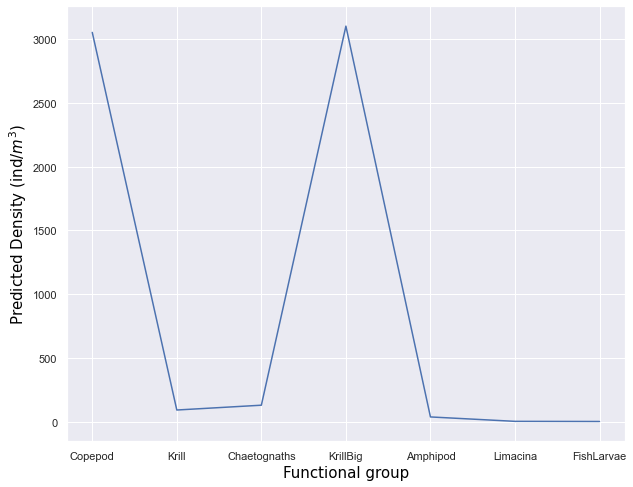

In [105]:
fig=plt.figure(figsize=(10, 8),facecolor='w', edgecolor='k')
plt.plot(specs,density[:])
plt.ylabel('Predicted Density (ind/$m^3$)', axis_font)
plt.xlabel('Functional group', axis_font)

### Compare the predicted sv with the measured sv

Text(0.5, 0, 'Frequency (kHz)')

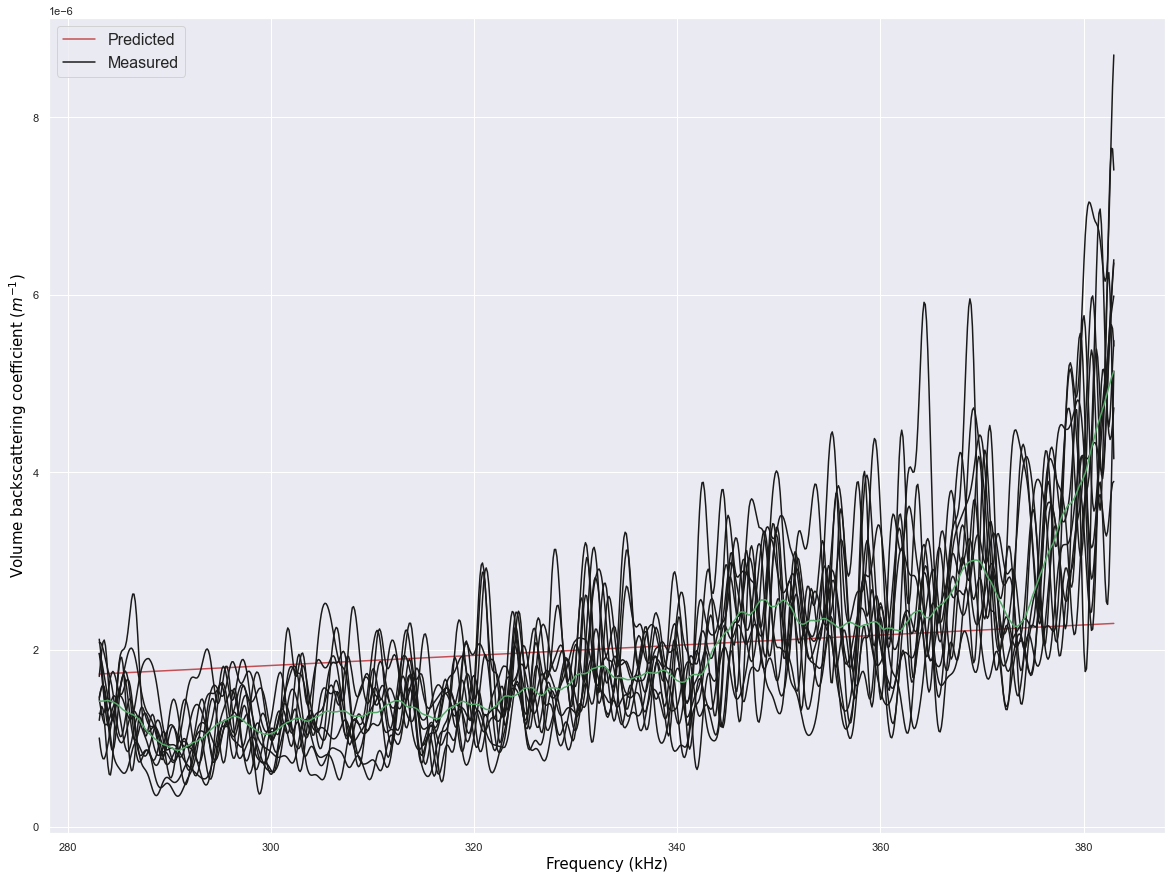

In [106]:
fig=plt.figure(figsize=(20, 15))
#for ind in range(0, np.shape(sv)[1]):
    #plt.plot(freqs_EV,np.sum(sigbs*density[:,ind],1),'r', freqs_EV ,sv[:,ind],'k', freqs_EV, sv_smooth, 'g')
plt.plot(freqs_EV,np.sum(sigbs*density,1),'r', freqs_EV , sv,'k', freqs_EV, sv_smooth, 'g')
plt.legend(['Predicted', 'Measured'], fontsize=16)
plt.ylabel('Volume backscattering coefficient ($m^{-1}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)

Also try with ‘bvls’ : Bounded-variable least-squares algorithm. This is an active set method, which requires the number of iterations comparable to the number of variables. Can’t be used when A is sparse or LinearOperator.
**not good results**

### try steepest descent? As used by...
Machine learning linear regression solvers could also be used for this.
First, the solver solves the linear equation and reiterates until it finds the solution with the minimum error.

I am not having much sucess with the straight forward of this method yet. It will only iterate the minimum number of times and if I give and input it does not change it.

BUT this method provides a intercept! This would be analagous to the noise I think.

In [107]:
#abundance from MultinetDataSP2018_ST7-18_Flaket.xlsx
density_init=[20, 20, 7, 10, 4, 10, 5]

In [108]:
density_SGD = np.zeros([np.shape(sigma_bs_mean)[1]])
density_intercept = np.zeros([np.shape(sv)[1]])
     # Always scale the input. The most convenient way is to use a pipeline.
reg = linear_model.SGDRegressor(warm_start=True,n_iter_no_change=10)
reg.fit(sigbs, arr.array('d',sv_smooth),coef_init=density_init) # Can apply weights
density_SGD = reg.coef_
density_intercept = reg.intercept_

Text(0.5, 0, 'Functional group')

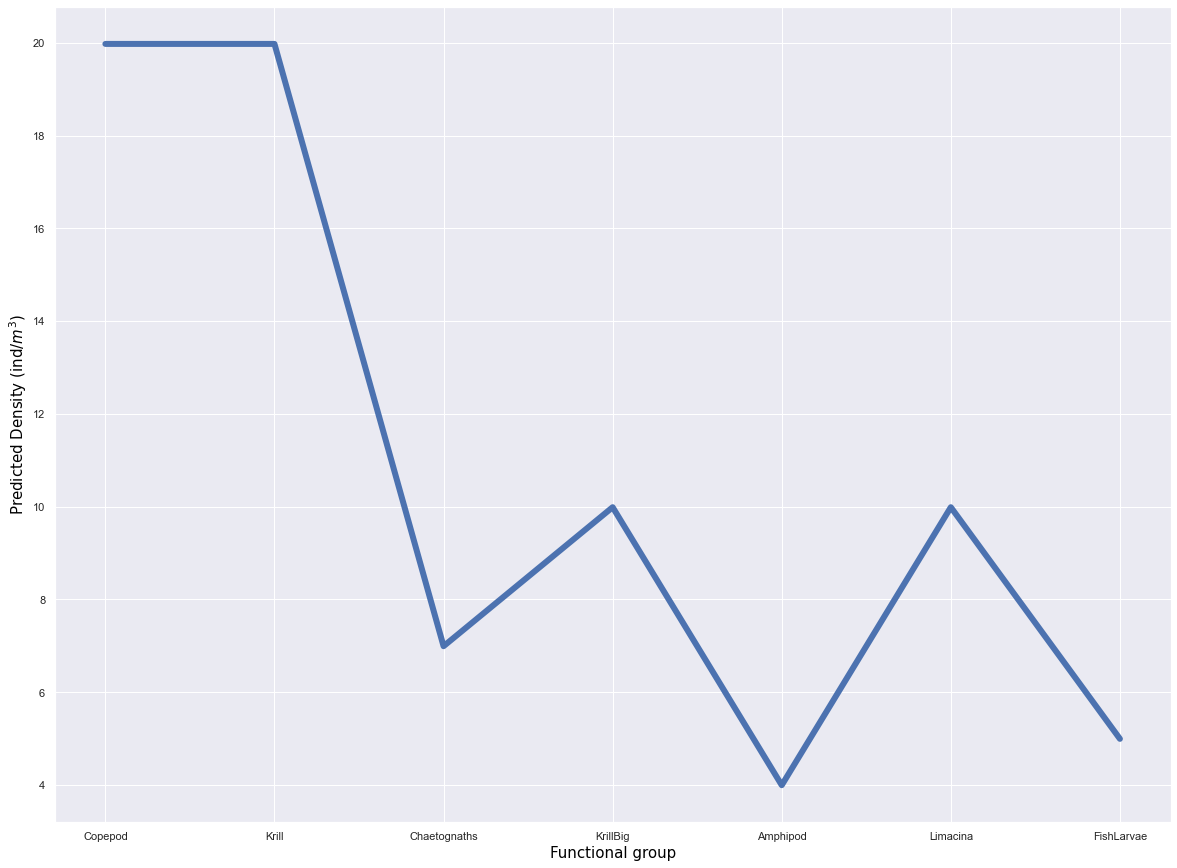

In [109]:
fig=plt.figure(figsize=(20, 15),facecolor='w', edgecolor='k')
plt.plot(specs, density_SGD, linewidth=6)
plt.ylabel('Predicted Density (ind/$m^3$)', axis_font)
plt.xlabel('Functional group', axis_font)

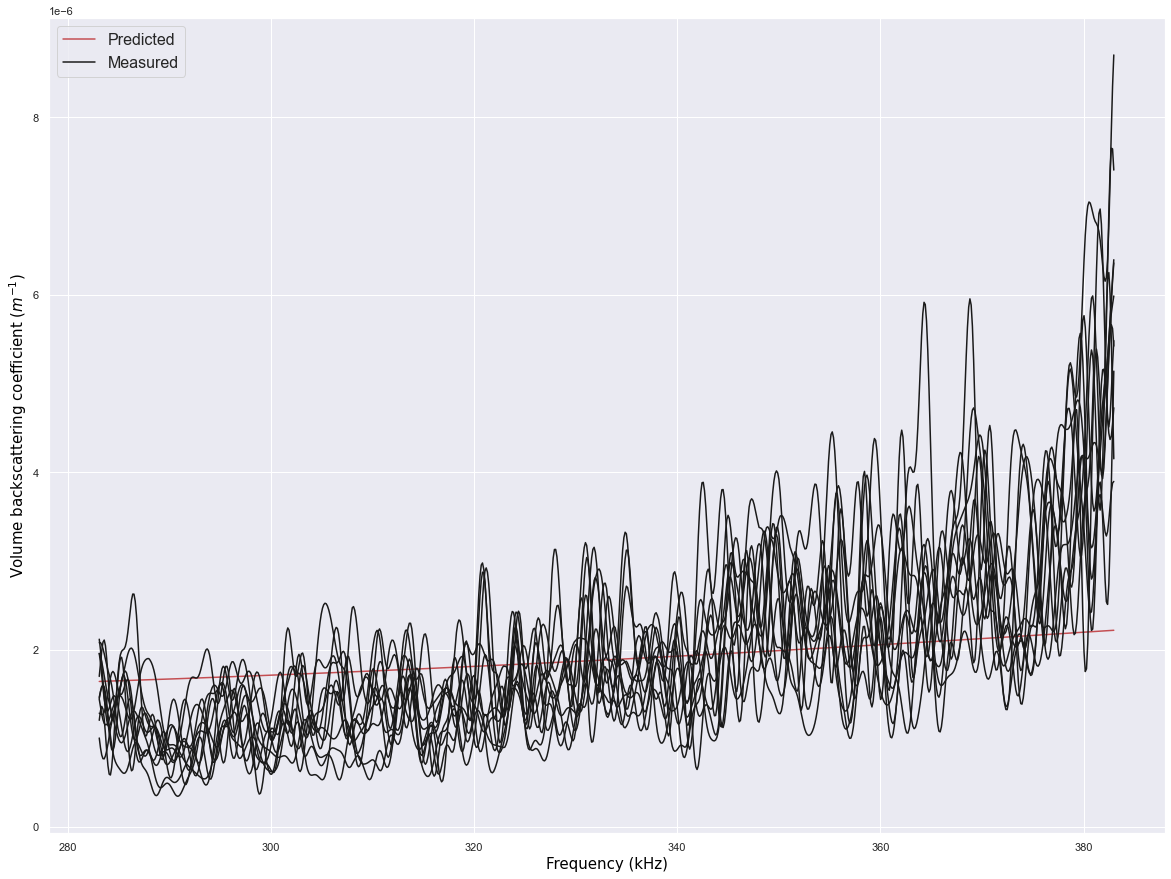

In [110]:
fig=plt.figure(figsize=(20, 15))
plt.plot(freqs_EV ,np.sum(sigbs*density_SGD,1)+density_intercept,'r')
plt.plot(freqs_EV, sv,'k')
plt.legend(['Predicted', 'Measured'], fontsize=16)
plt.ylabel('Volume backscattering coefficient ($m^{-1}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font);

What does intercept represent?? Noise??
Either way **BAD prediction**

# Noise
Should noise be included as one of the parameters? 
It always follows the same pattern with the same peaks? Why?

In [111]:
fname_noise = 'D:/GLIDER2018/Echosounder/EVexport/Wideband_frequency_response_noise.csv'
freqs_EV, sv_noise = inv.read_widebandfrequencyresponse(fname_noise, extracols = 0)

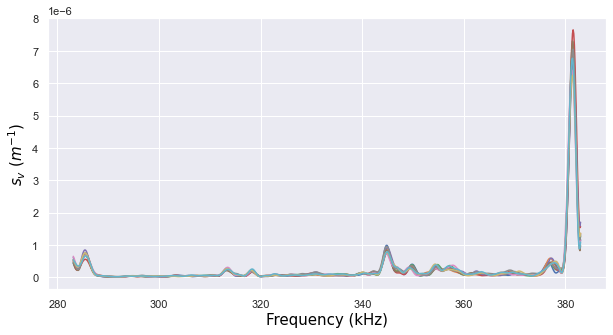

In [112]:
fig=plt.figure(figsize=(10, 5))
plt.plot(freqs_EV,sv_noise)
plt.ylabel('$s_v$ ($m^{-1}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font);